## Euler-Murayama Method
We consider the following SDE
$$X_t=-\sin X_t(\cos X_t)^3dt + (\cos X_t)^2dB_t$$
$$X_0=x_0\in\mathbb{R}, t\in[0,T]$$

Let us solve this SDE using the Euler-Murayama scheme with all paths being computed at the same time.

1. Check whether the assumptions of (i) the existence and uniqueness Theorem 4.2.3, (ii) the strong convergence theorem for the Euler-Maruyama method, Theorem 5.1.3, are satisfied.

Use It^o's formula to show that the analytical solution is given by $X_t=\arctan(Bt + \tan(x_0))$ for $t\in[0,T]$.
Hint: You can use $\phi(X_t)=\tan(X_t)$ in Ito's formula.


2. ...

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn

def brownp(T, N, M=1):
    # find M paths of Brownian motion
    # each column of x contains values at t=T/N, 2*T/N, ... , T
    if M == 1:
        x = np.hstack([0, np.cumsum(np.random.normal(0, np.sqrt(T/N), N))])
    else:
        x = np.zeros((N+1, M))
        for i in range(M):
            x[:, i] = np.hstack([0, np.cumsum(np.random.normal(0, np.sqrt(T/N), N))])
    return x

def sde_convstrong():
    # SDE X_t = f(X_t,t)dt + g(X_t,t)dB_t
    #     X_0 = x0; t in [0,T] is solved using the EM method
    #
    # all paths are computed at the same time
    N0 = 10                             # number of steps on coarsest level
    L = 5                               # number of refinement steps
    M = 10**4                           # number of samples 

    T = 1                               # final time
    x0 = 1                              # initial condition
    f = lambda x, t: -np.sin(x) * np.cos(x) ** 3 # coeffients of the SDE
    g = lambda x, t: np.cos(x) ** 2

    NL = N0 * 2 ** L
    B = brownp(T, NL, M)                # paths of Brownian motion on finest level
    YT = np.zeros((L + 1, M))           # values of X_T for h=T/(N*2^l), l=0,...,L, all m
    tic = time.perf_counter()
    for l in range(L + 1):              # for N = N0, N0*2, ... , N0*2^L
        N = N0 * 2 ** l
        p = 2 ** (L - l)                # p = NL/N
        h = T / N 
        Y = np.zeros((N + 1, M))
        Y[0, :] = x0
        for j in range(N):              # perform N steps of E-M method:
            dB = B[1 + j * p, :] - B[1 + (j - 1) * p, :]
            t = j * h
            x = Y[j, :]
            Y[j + 1, :] = x + f(x, t) * h + g(x, t) * dB
        YT[l, :] = Y[-1, :]            # values of X_T
    # strong convergence :              
    exact = np.arctan(B[-1, :] + np.tan(x0))
    YTe = np.abs(YT - np.tile(exact, (L + 1, 1))) # errors for XT
    YTem = np.mean(YTe, axis=1)       # mean errors for strong convergence
    YTem2 = np.sum(YTe ** 2, axis=1) ** 0.5 # mean square errors for strong convergence

    Lp = L                             # plot results for l=0,...,Lp 
    hv = T / (N * 2 ** np.arange(Lp + 1)) 
    hL = hv[-1]
    p = hv[0] / hL

    plt.loglog(hv, YTem2, '-gx', hv, YTem, '-ro', hL * np.array([1, p]), 
               YTem[-1] * np.array([1, p ** 0.5]), hL * np.array([1, p]), 
               YTem2[-1] * np.array([1, p ** 0.5]))
    plt.legend(['strong error in L^1', 'strong error in L^2', 'h^{1/2}', 'h^{1/2}'])
    plt.grid(True)
    plt.xlabel('step size h')


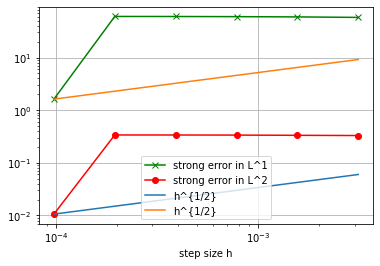

In [2]:
sde_convstrong()

We observe a convergence rate of 0:5 in both cases when we average over $M$ sample paths. The scheme also converges when we use one sample path but the rate is hard to determine and the variance is large.

## Weak convergence


In [3]:
def sde_convweak():
    # SDE X_t = f(X_t,t)dt + g(X_t,t)dB_t
    #     X_0 = x0; t in [0,T] is solved using the EM method
    #
    # all paths are computed at the same time
    N0 = 10                           # number of steps on coarsest level
    L = 4                             # number of refinement steps
    M = 5*10**4                       # number of samples 
    itera = 10
    T = 1                             # final time
    x0 = 1                            # initial condition

    f = lambda x,t: -np.sin(x) * np.cos(x)**3   # coefficients of the SDE
    g = lambda x,t: np.cos(x)**2
    G = lambda x: np.maximum(x - 1.1, 0)

    NL = N0 * 2**L
    B = brownp(T, NL, M)             # paths of Brownian motion on finest level
    YT = np.zeros((L+1, M))          # values of X_T for h=T/(N*2^l), l=0,...,L, all m
    Erro1 = np.zeros(L+1)
    Erro2 = np.zeros(L+1)

    tic = time.time()
    for it in range(itera):
        for l in range(L+1):         # for N = N0, N0*2, ... , N0*2^L
            N = N0 * 2**l
            p = 2**(L-l)             # p = NL/N
            h = T / N
            Y = np.zeros((N+1, M))
            Y[0, :] = x0
            for j in range(N):       # perform N steps of E-M method:
                dB = B[(j*p)+1, :] - B[j*p, :]
                t = j * h
                x = Y[j, :]
                Y[j+1, :] = x + f(x, t) * h + g(x, t) * dB
            YT[l, :] = Y[N, :]      # values of X_T
        Z = G(YT)                   # compute payoffs

        # weak convergence :
        Ym = np.mean(Z, axis=1)
        Ymex = np.mean(G(np.arctan(np.random.randn(1, int(1e7)) * np.sqrt(T) + np.tan(x0))))
        # sample means for Y
        Yme = np.abs(Ym - Ymex)     # error in means for weak convergence
        Erro1 += Yme
        Erro2 += Yme ** 2

    Erro1 /= itera
    Erro2 /= itera
    Lp = L   
                          
    hv = T / (N * 2.**(np.arange(Lp+1)))    # step sizes h for each level
    hL = hv[-1]                     # finest step size
    p = hv[0] / hL
    
    # plot results
    plt.loglog(hv, Erro1, '-gx', hv, Erro2, '-ro', hL*np.array([1, p]), Erro1[-1] * np.array([1, p**1.0]), hL*np.array([1, p]), Erro2[-1] * np.array([1, p**1.0]))
    plt.legend(['weak error in $L^1$', 'weak error in $L^2$', '$h^1$', '$h^1$'])
    plt.grid(True)
    plt.xlabel('step size $h$')
    plt.ylabel('error')
    
    # compute convergence rate
    p = np.polyfit(np.log(hv), np.log(Erro2), 1)
    print('Weak rate of convergence $L^2$: {:.4f}'.format(p[0]))

    p = np.polyfit(np.log(hv), np.log(Erro1), 1)
    print('Weak rate of convergence $L^1$: {:.4f}'.format(p[0]))


Weak rate of convergence $L^2$: 3.7173
Weak rate of convergence $L^1$: 1.8655


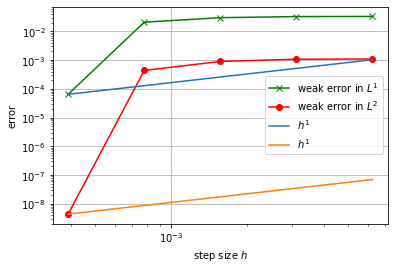

In [4]:
sde_convweak()

We observe a weak rate of 1 in both cases. The observed rate depends on the sample size $M$. If $M$ is not chosen sufficiently large the rate of convergence may decrease, as in this case the total error s dominated by the sampling error.

## Milstein scheme
This code implements the strong convergence test for the Euler-Maruyama method for solving stochastic differential equations (SDEs). It computes the errors of the EM method for solving an SDE with given coefficients f and g, and compares them against the exact solution for the SDE.

The SDE is of the form dX = f(X,t)dt + g(X,t)dBt, where X is the solution process, t is time, and Bt is a standard Brownian motion. The EM method uses the following formula to update the solution at each time step: X_{n+1} = X_n + f(X_n, t_n)Δt + g(X_n, t_n)(B_{n+1} - B_n), where Δt is the time step and B_{n+1} - B_n is a sample of a standard normal distribution.

The code first sets some parameters: N0 is the number of steps on the coarsest level, L is the number of refinement steps, M is the number of samples. T is the final time of the simulation, x0 is the initial condition, and f, g, and hfu are functions defining the coefficients of the SDE.

Then, the code generates paths of Brownian motion B using the brownp function, and computes the values of the solution process X at time T for different values of the time step h using the EM method. It stores the results in the matrix YT, where each row corresponds to a different value of h.

The code then computes the errors of the EM method by comparing the values of X_T in YT to the exact solution of the SDE, and stores them in the vectors YTem and YTem2. It also plots the results and computes the convergence rate of the method.

Finally, the code displays the convergence rate and the time taken to run the simulation using the tic-toc functions.

In [5]:
def sde_convstrongmil():
    # SDE X_t = f(X_t,t)dt + g(X_t,t)dB_t
    # X_0 = x0; t in [0,T] is solved using the EM method
    #
    # all paths are computed at the same time
    N0 = 10                           # number of steps on coarsest level
    L = 6                            # number of refinement steps
    M = 10**4                        # number of samples 

    T = 1                            # final time
    x0 = 1                           # initial condition
    f = lambda x,t: -np.sin(x)*(np.cos(x))**3   # coefficients of the SDE
    g = lambda x,t: np.cos(x)**2
    hfu = lambda x,t: 2*np.cos(x)**3*(-np.sin(x))

    NL = N0*2**L
    B = brownp(T, NL, M)             # paths of Brownian motion on finest level
    YT = np.zeros((L+1,M))           # values of X_T for h=T/(N*2^l), l=0,...,L, all m
    tic = time.time()
    for l in range(L+1):             # for N = N0, N0*2, ... , N0*2^L
        N = N0*2**l
        p = 2**(L-l)                # p = NL/N
        h = T/N 
        Y = np.zeros((N+1,M))
        Y[0,:] = x0
        for j in range(N):          # perform N steps of E-M method:
            dB = B[1+j*p,:] - B[1+(j-1)*p,:]
            t = j*h
            x = Y[j,:]
            Y[j+1,:] = x + f(x,t)*h + g(x,t)*dB
            Y[j+1,:] = x + f(x,t)*h + g(x,t)*dB+0.5*hfu(x,t)*(dB**2-h)
        YT[l,:] = Y[N,:]           # values of X_T
    # strong convergence:
    exact = np.arctan(B[-1,:]+np.tan(x0))
    YTe = np.abs(YT - np.tile(exact, (L+1, 1)))   # errors for XT
    YTem = np.mean(YTe, axis=1)           # mean errors for strong convergence
    YTem2 = np.sum(YTe**2, axis=1)**0.5   # mean square errors for strong convergence

    Lp = L                       # plot results for l=0,...,Lp 
    hv = T/(N*2**np.arange(Lp+1))
    hL = hv[-1]
    p = hv[0]/hL

    plt.loglog(hv, YTem2, '-gx', hv, YTem, '-ro', hL*np.array([1, p]), YTem[-1]*np.array([1, p**1]), 
               hL*np.array([1, p]), YTem2[-1]*np.array([1, p**1]))
    plt.legend(['strong error in L^1', 'strong error in L^2', 'h^{1}', 'h^{1}'])
    plt.grid(True)
    plt.xlabel('step size h')
    plt.ylabel('error')
    #


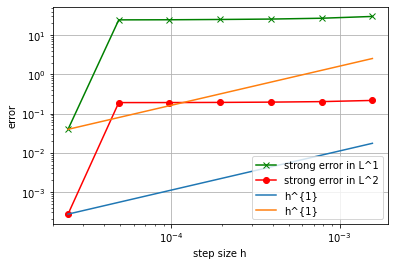

In [6]:
sde_convstrongmil()

We observe a strong rate of 1 in both cases. The weak rate is also 1.